In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from util import show_status, load_batch, log_interp

In [18]:
show_status("./status.json")

Algorithm|Implemented|Status|Notes / Issues|Possible Solutions
---|---|---|---|---
CFR|✅|✅|None|N/A
DeepCFR|✅|❌|Does not converge|~~try Brown et al. params~~
ED|✅|❌|Does not converge|Parameter sweep from paper
XFP|✅|✅|None|N/A
NFSP|✅|✅*|better than OS reported; OS inconsistent w/ Heinrich Silver|~~Try ARMAC params~~, ~~try heinrich silver params~~
RPG / RMPG|✅|❌|N/A|N/A
QPG|✅|❌|N/A|N/A
PSRO|✅|❌|N/A|N/A
RCFR|✅|✅|sensitive to LR, can manipulate to match OpenSpiel & waugh et al.|~~larger network~~, ~~smaller LR~~


# Figure 1
Convergence rates of XFP and ED algorithms on various partially-observable games in OpenSpiel. The units of the x-axis is iterations and the units of the y-axis is NashConv. Figure taken from [47]

### Notes:
- in ED paper: "We performed a sweep over the number of hidden layers (from 1 to 5), the number of hidden units (64, 128 or 256), the regularization weight (10^-7, 10^-6, 10^-5, 10^-4), and the initial learning rate (powers of 2). The plotted results show the best values from this sweep for each game."

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

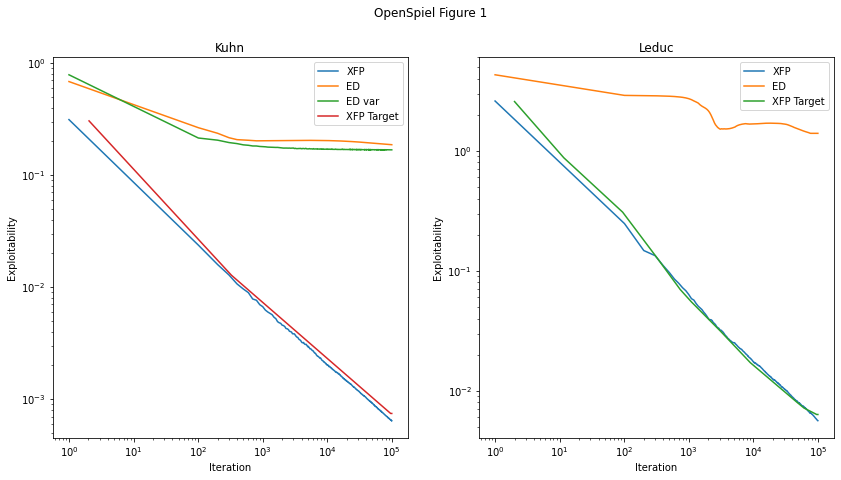

In [17]:
kuhn_logs = [#("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/xfp_kuhn_0.csv", "XFP"),
            ("./logs/exp_descent_kuhn_1.csv", "ED"),
             #("./logs/exp_descent_kuhn_128_2_-4_1.csv", "ED var"),
             #("./target_results/fig1_cfr_kuhn.csv", "CFR Target"),
             ("./target_results/fig1_xfp_kuhn.csv", "XFP Target"),
            #("./target_results/fig1_ed_kuhn.csv", "ED Target")
            ]

leduc_logs = [#("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/xfp_leduc_1.csv", "XFP"),
              ("./logs/exp_descent_leduc_1.csv", "ED"),
              #("./target_results/fig1_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig1_xfp_leduc.csv", "XFP Target")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# correct for exp = NashConv / 2
#kuhn_dat["ED Target"] /= 2
kuhn_dat["XFP Target"] /= 2
#leduc_dat["CFR Target"] /= 2
leduc_dat["XFP Target"] /= 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.suptitle('OpenSpiel Figure 1')

ax = kuhn_dat.plot(title="Kuhn", logx=True, logy=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-7, 1))

ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-4, 10))

# Figure 2
Convergence rate of RCFR in Leduc poker using a 2-layer network with 400 hidden units in each layer. The average policy is computed exactly (i.e. tabular), and regression targets are the
cumulative predicted regrets.

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

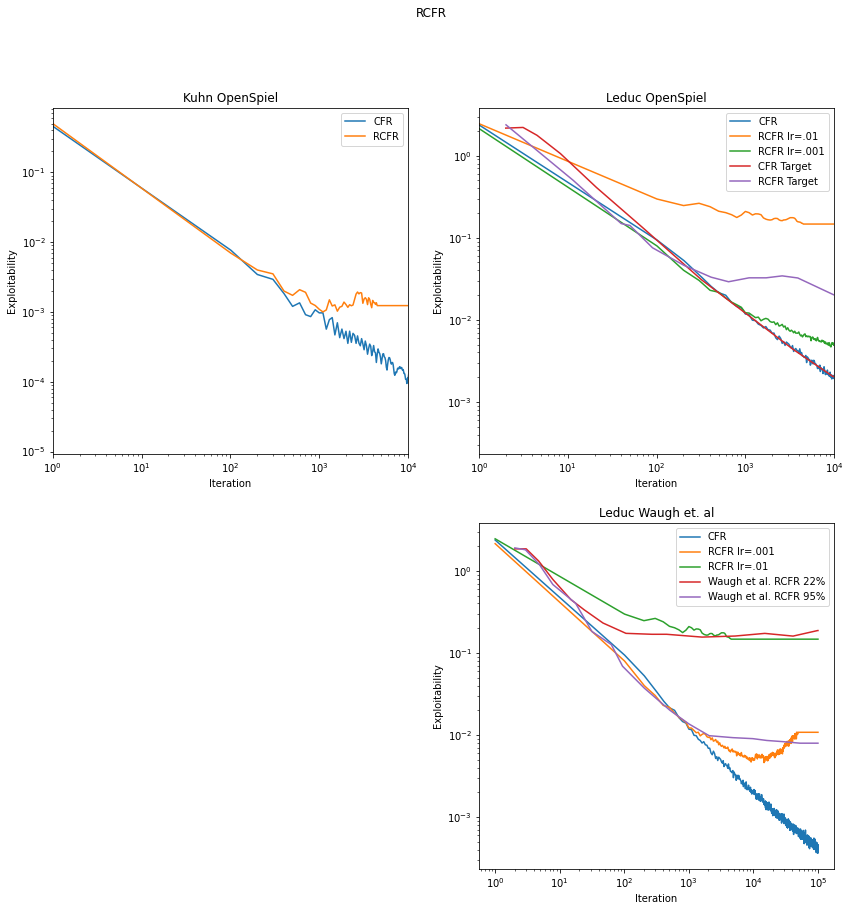

In [2]:
kuhn_logs = [("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/rcfr_kuhn_3.csv", "RCFR"),
            ]

leduc_logs = [("./logs/cfr_leduc_2.csv", "CFR"),
              #("./logs/rcfr_leduc_lr10-1_0.csv", "RCFR lr=.1"),
              ("./logs/rcfr_leduc_1.csv", "RCFR lr=.01"),
              ("./logs/rcfr_leduc_lr10-3_0.csv", "RCFR lr=.001"),
              ("./target_results/fig2_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig2_rcfr_leduc.csv", "RCFR Target"),
              ("./target_results/rcfr_waugh_leduc_22.csv", "Waugh et al. RCFR 22%"),
              ("./target_results/rcfr_waugh_leduc_95.csv", "Waugh et al. RCFR 95%")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# milli blind conversion, additional 1/10 scale correct for error in plot extraction
leduc_dat["Waugh et al. RCFR 22%"] *= .0001
leduc_dat["Waugh et al. RCFR 95%"] *= .0001

# nash conv -> exp
leduc_dat["CFR Target"] /= 2
leduc_dat["RCFR Target"] /= 2

log_log = True
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.suptitle('RCFR')
fig.delaxes(axes[1,0])

ax = kuhn_dat.plot(title="Kuhn OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))

os_targets = ["CFR", "RCFR lr=.01", "RCFR lr=.001", "CFR Target", "RCFR Target"]
ax = leduc_dat[os_targets].plot(title="Leduc OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))
#ax.set_ylim((10e-4, 10))

waugh_targets = ["CFR", "RCFR lr=.001", "RCFR lr=.01", "Waugh et al. RCFR 22%", "Waugh et al. RCFR 95%"]
ax = leduc_dat[waugh_targets].plot(title="Leduc Waugh et. al", logy=log_log, logx=log_log, ax=axes[1,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e3))

# Figure 3
Convergence rates of NFSP and various (regret-based) policy gradient algorithms in 2-player Leduc poker. Each line is an __average over the top five seeds and hyperparemeter settings for each algorithm__. The lowest (around 0.2) exploitability value reached by any individual run is depicted by a dashed line.

In [15]:
leduc_dat.tail()

,NFSP 128,NFSP 16,NFSP OS default,OpenSpiel,Heinrich Silver 16,Heinrich Silver 128
iteration,,,,,,
56540001.0,0.203990,0.588735,0.109048,0.334332,0.225395,0.060516
56550001.0,0.201828,0.588735,0.109048,0.334332,0.225395,0.060516
56560001.0,0.191921,0.588735,0.109048,0.334332,0.225395,0.060516
56570001.0,0.197462,0.588735,0.109048,0.334332,0.225395,0.060516
56580001.0,0.195581,0.588735,0.109048,0.334332,0.225395,0.060516


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

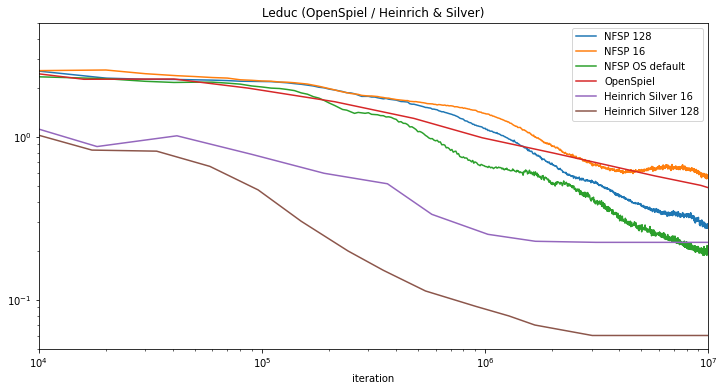

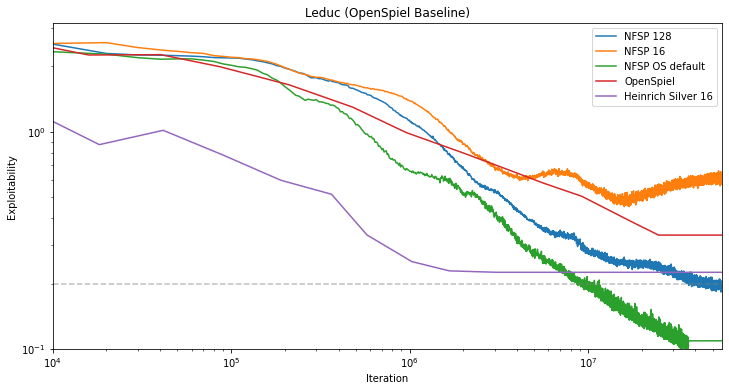

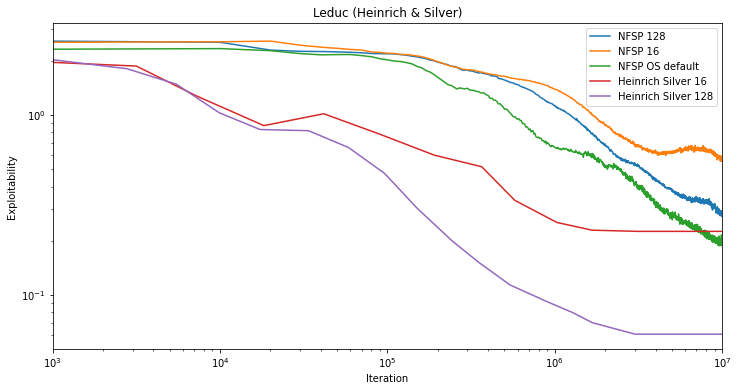

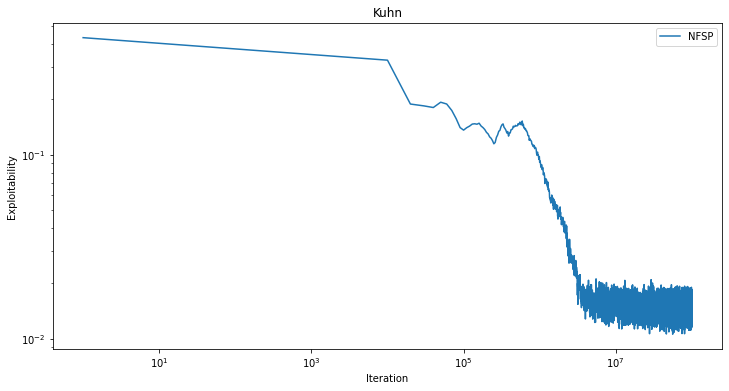

In [13]:
kuhn_logs = [("./logs/nfsp_kuhn_2.csv", "NFSP")
            ]

leduc_logs = [("./logs/nfsp_leduc_orig_128_0.csv", "NFSP 128"),
              ("./logs/nfsp_leduc_orig_16_0.csv", "NFSP 16"),
              ("./logs/nfsp_leduc_2.csv", "NFSP OS default"),
              #("./logs/nfsp_leduc_3.csv", "NFSP3"),
              #("./logs/nfsp_leduc_4.csv", "NFSP4"),
              #("./logs/nfsp_leduc_5.csv", "NFSP5"),
              ("target_results/fig3_nfsp_leduc.csv", "OpenSpiel"),
              ("target_results/nfsp_heinrich_silver_16.csv", "Heinrich Silver 16"),
              ("target_results/nfsp_heinrich_silver_leduc_128.csv", "Heinrich Silver 128")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1)).dropna()
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

#leduc_dat["Heinrich Silver 16"] /= 2

#leduc_mean = pd.DataFrame(leduc_dat[["NFSP1","NFSP2","NFSP3","NFSP4","NFSP5",]].mean(1), columns=["NFSP"])
#avg_leduc = leduc_dat[["OpenSpiel", "Heinrich Silver 128"]].join(leduc_mean)
ax = leduc_dat.plot(title="Leduc (OpenSpiel / Heinrich & Silver)", loglog=True, figsize=(12,6))
ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 1e7))

ax = leduc_dat.drop("Heinrich Silver 128", axis=1).plot(title="Leduc (OpenSpiel Baseline)", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.axhline(y=0.2, color='gray', alpha=.5, linestyle='--')
ax.set_ylim((.1))
ax.set_xlim((1e4, max(leduc_dat.index)))

ax = leduc_dat.drop("OpenSpiel", axis=1).plot(title="Leduc (Heinrich & Silver)", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_ylim((.01, 10))
ax.set_xlim((1e3, 1e7))

ax = kuhn_dat.plot(title="Kuhn", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")

# DeepCFR

Text(0.5, 0.98, 'DeepCFR')

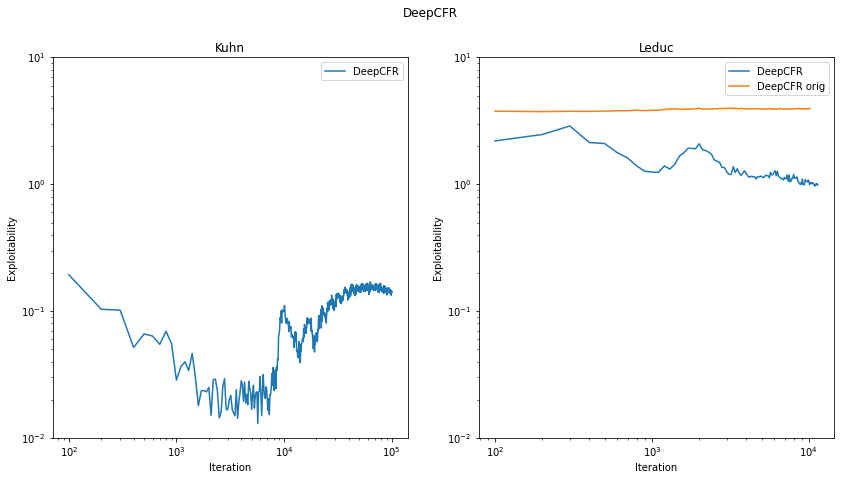

In [16]:
kuhn_logs = [("./logs/deep_cfr_kuhn_0.csv", "DeepCFR")
            ]

leduc_logs = [("./logs/deep_cfr_leduc_4.csv", "DeepCFR"),
              ("./logs/deep_cfr_leduc_10kbatch_reinitVF_1.csv", "DeepCFR Brown et al.")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
fig.suptitle('DeepCFR')

# PSRO